# 11. RNN을 이용한 텍스트 분류(Text Classification)

## 1) 로이터 뉴스 분류하기(Reuters News Classification)

로이터 뉴스 데이터를 LSTM을 이용하여 텍스트 분류를 진행

### - 데이터 이해
: 로이터 뉴스 기사 데이터는 총 11,258개의 뉴스 기사가 46개의 뉴스 카테고리로 분류되는 뉴스 기사 데이터이다.

In [ ]:
# 케라스 데이터셋으로부터 로이터 뉴스 기사 데이터를 다운로드
from tensorflow.keras.datasets import reuters
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# 데이터를 훈련용과 테스트용으로 나누기
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
# num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절
# 모든 단어를 사용하고자 한다면 None으로 설정

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1  #y_train는 0부터 시작하는 숫자들로 카테고리 라벨을 부여하므로, 가장 큰 수에 +1을 하여 출력
print('카테고리 : {}'.format(num_classes))

훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


In [ ]:
print(X_train[0]) # 첫번째 훈련용 뉴스 기사
print(y_train[0]) # 첫번째 훈련용 뉴스 기사의 레이블
# 이 데이터는 토큰화과 정수 인코딩(각 단어를 정수로 변환)이 끝난 상태임

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


- 데이터는 단어들이 몇 번 등장하는 지의 빈도에 따라서 인덱스를 부여

뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


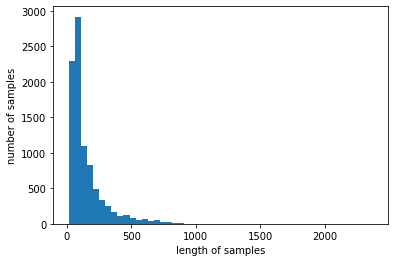

In [ ]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))
# sum(각 트레인 길이 / 전체 트레인 갯수)

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 대부분의 뉴스가 100~200 사이로 보임임

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


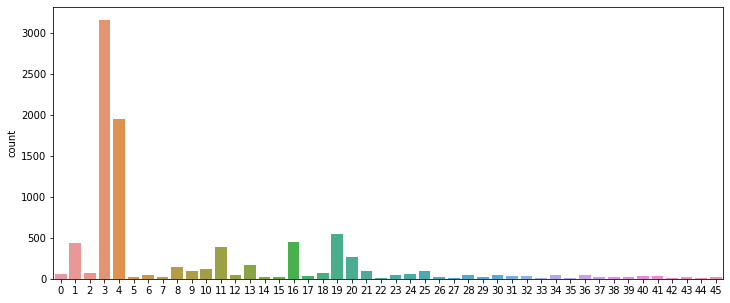

In [ ]:
# 레이블 값의 분포
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5). #figsize
sns.countplot(y_train)
plt.show()
# 3, 4가 가장 많은 레이블을 차지

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
# print(np.asarray((unique_elements, counts_elements)))
label_cnt=dict(zip(unique_elements, counts_elements))
print(label_cnt)

각 레이블에 대한 빈도수:
{0: 55, 1: 432, 2: 74, 3: 3159, 4: 1949, 5: 17, 6: 48, 7: 16, 8: 139, 9: 101, 10: 124, 11: 390, 12: 49, 13: 172, 14: 26, 15: 20, 16: 444, 17: 39, 18: 66, 19: 549, 20: 269, 21: 100, 22: 15, 23: 41, 24: 62, 25: 92, 26: 24, 27: 15, 28: 48, 29: 19, 30: 45, 31: 39, 32: 32, 33: 11, 34: 50, 35: 10, 36: 49, 37: 19, 38: 19, 39: 24, 40: 36, 41: 30, 42: 13, 43: 21, 44: 12, 45: 18}


In [ ]:
word_to_index = reuters.get_word_index()
# reuters.get_word_index는 각 단어와 그 단어에 부여된 인덱스를 리턴
# print(word_to_index)

In [ ]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

print('빈도수 상위 28842번 단어 : {}'.format(index_to_word[28842]))
# nondiscriminatory : 차별 대우가 없는

빈도수 상위 28842번 단어 : nondiscriminatory


In [ ]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))

빈도수 상위 1번 단어 : the


In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token  # index_to_word의 입력으로 넣고 이를 계속해서 저장

# X_train[0] 기사 복원
print(' '.join([index_to_word[index] for index in X_train[0]]))
# 정수 인코딩을 수행하기 전에도 어느정도 전처리가 된 상태라서 제대로 된 문장이 나오지는 않는다.

<sos> wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs


### - LSTM으로 로이터 뉴스 분류하기

In [ ]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
# 등장 빈도 순서가 가장 많은 상위 1 ~ 1,000번째인 단어들만 사용
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 뉴스 기사 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 뉴스 기사 패딩

In [ ]:
y_train = to_categorical(y_train) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 뉴스 기사 레이블의 원-핫 인코딩

- 모델 설계

In [ ]:
model = Sequential()
model.add(Embedding(1000, 120))  # Embedding(집합의 크기, 임베딩 벡터의 차원)
# 위 코드에서 Embedding()은 120의 차원을 가지는 임베딩 벡터를 1,000개 생성하는 역할
model.add(LSTM(120))   # LSTM(메모리 셀의 은닉 상태의 크기(hidden_size))
model.add(Dense(46, activation='softmax'))  # 46개의 카테고리를 분류해야하므로, 출력층에서는 46개의 뉴런을 사용
# 소프트맥스 함수는 각 입력에 대해서 46개의 확률 분포를 만들어 낸다.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# categorical_crossentropy는 모델의 예측값과 실제값에 대해서 두 확률 분포 사이의 거리를 최소화하도록 훈련

In [ ]:
# 모델 학습
# val_loss가 줄어들다가 증가하는 상황이 오면 과적합(overfitting)으로 판단하기 위해
# validation_data로 X_test와 y_test를 사용

history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
71/71 [==============================] - 30s 392ms/step - loss: 3.0119 - acc: 0.3174 - val_loss: 2.0944 - val_acc: 0.4893

Epoch 00001: val_acc improved from -inf to 0.48931, saving model to best_model.h5
Epoch 2/30
71/71 [==============================] - 28s 401ms/step - loss: 2.0454 - acc: 0.4882 - val_loss: 1.9746 - val_acc: 0.5169

Epoch 00002: val_acc improved from 0.48931 to 0.51692, saving model to best_model.h5
Epoch 3/30
71/71 [==============================] - 28s 401ms/step - loss: 1.9742 - acc: 0.4818 - val_loss: 1.7792 - val_acc: 0.5454

Epoch 00003: val_acc improved from 0.51692 to 0.54541, saving model to best_model.h5
Epoch 4/30
71/71 [==============================] - 28s 398ms/step - loss: 1.7654 - acc: 0.5419 - val_loss: 1.7136 - val_acc: 0.5561

Epoch 00004: val_acc improved from 0.54541 to 0.55610, saving model to best_model.h5
Epoch 5/30
71/71 [==============================] - 28s 393ms/step - loss: 1.6329 - acc: 0.5743 - val_loss: 1.6927 - val_acc: 0

Epoch 23에서 early stopping


In [ ]:
# 정확도 측정
# 훈련 과정에서 검증 데이터가 가장 높았을 때 저장된 모델로 성능을 평가

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
# 케라스의 model.fit()에서 validation_data는 실제 기계가 데이터를 훈련하지는 않고 에포크마다 정확도와 loss를 출력하여 과적합을 판단하기 위한 용도로만 사용된다.
# 다시말해, validation_data에서 이미 X_test, y_test를 사용했지만 기계는 아직 이 데이터로 학습한 적이 없는 상태인 것이다.
# 그래서 모델이 학습하지 않은 데이터인 X_test, y_test를 테스트 데이터로서 성능 평가 용도로 model.evaluate()에서도 다시 사용
# 그러나, 데이터가 충분하다면, 검증 데이터와 테스트 데이터는 다르게 사용하는 것이 좋다.

71/71 [==============================] - 3s 31ms/step - loss: 1.2148 - acc: 0.7093

 테스트 정확도: 0.7093


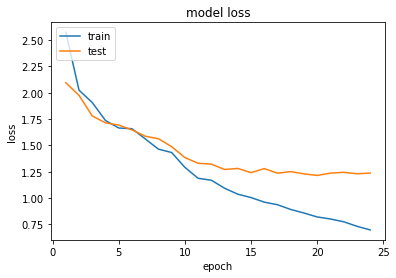

In [ ]:
# 에포크마다 변화하는 훈련 데이터와 검증 데이터(테스트 데이터)의 손실 그리기

epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

전체적으로는 검증 데이터의 손실이 줄어드는 경향이 있지만 뒤로 갈수록 점차 검증 데이터의 손실이 증가하려고 하는 경향이 보임.
이는 과적합의 신호일 수 있다.

## 2) 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis)
: 영화 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1을 부정인 경우 0으로 표시한 레이블로 구성되어 있음

- 한국어/한글 데이터에 대해서 텍스트 분류를 수행
- 한국어 데이터는 토큰화(tokenization)를 할 때 형태소 분석기를 사용

### - 데이터에 대한 이해와 전처리

In [ ]:
pip install konlpy

     |████████████████████████████████| 19.4MB 28.1MB/s 
     |████████████████████████████████| 460kB 43.9MB/s 
     |████████████████████████████████| 92kB 10.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 데이터 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f016e6d8b50>)

In [ ]:
# 불러온 데이터를 훈련 데이터는 train_data에 테스트 데이터는 test_data에 저장
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [ ]:
train_data[:5] # 상위 5개 출력
# 리뷰가 긍정(1), 부정(0)
# 세번째 샘플은 띄어쓰기 무시

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [ ]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
# 데이터 정제하기
train_data['document'].nunique(), train_data['label'].nunique()

# 중복 데이터 확인
# document열에서 중복을 제거한 샘플의 개수가 146,182개라는 것은 약 4,000개의 중복 샘플이 존재한다는 의미
# label 열은 0 또는 1의 값만을 가지므로 2가 출력

(146182, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


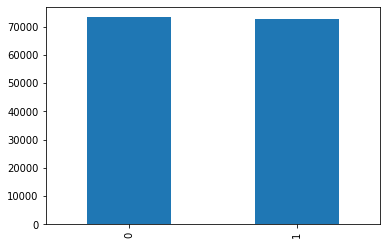

In [ ]:
# train_data 레이블(label) 값의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))
# 긍정과 부정 분포가 거의 비슷하게 보임
# 레이블이 0인 리뷰가 근소하게 많음

   label  count
0      0  73342
1      1  72841


In [ ]:
# Null 값 확인
print(train_data.isnull().values.any())
# True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미

True


In [ ]:
print(train_data.isnull().sum())
# document 열에서 Null 값을 가진 샘플이 총 1개가 존재

id          0
document    1
label       0
dtype: int64


In [ ]:
# Null 값을 가진 샘플 인덱스 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
# Null 값을 가진 샘플을 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
print(len(train_data))

146182


여기까지 정리된 데이터에 전처리를 수행한다.

- 한글만 남기고 특수문자나 기호를 제거하기 위해 정규 표현식을 사용
- 한글이 아닌 리뷰도 제거

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
# 정규표현식으로 한글만 골랐기 때문에 기존에 한글이 없는 리뷰였다면 이제 더 이상 아무런 값도 없는 빈(empty) 값이 됨
# data에 공백(white space)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 샘플 제거rain_data = train_data.dropna(how = 'any') # Null 샘플 제거
print(len(train_data))

145393


In [ ]:
# test_data에도 동일한 과정 적용
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


In [ ]:
# 토큰화 진행
# 토큰화 과정에서 불용어를 제거

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
# 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt를 사용
okt = Okt()

# Okt 예시
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)
#  stem = True를 사용하면 일정 수준의 정규화를 수행해 준다.
# '이런'이 '이렇다'로 변환되었고 '만드는'이 '만들다'로 변환된 것을 확인할 수 있다.

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [ ]:
X_train = []

#형태소 분석기를 사용하여 토큰화 진행
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [ ]:
# 테스트 데이터에 대해서도 동일하게 토큰화 진행

X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [ ]:
# 정수 인코딩
# 훈련 데이터에 대해서 단어 집합(vocaburary) 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# 각 단어에 고유한 정수가 부여
print(tokenizer.word_index)

In [ ]:
# 빈도수가 낮은 단어 정리를 위해 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
# 단어 집합에서 등장 빈도가 2회 이하인 단어의 비중이 절반이 넘는다.
# 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.87%로
# 희귀단어은 정수 인코딩 과정에서 배제한다.

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [ ]:
tokenizer = Tokenizer(vocab_size)
# 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환한다.
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


- 이제 단어의 개수는 19,416개로 제한 되었음
- 0번 단어는 패딩을 위한 토큰임

In [ ]:
# data에서 y_train과 y_test를 별도로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
# 빈 샘플(empty samples) 제거
# 앞서 희소 단어를 제거하면서 희소 단어들만으로 채워진 리뷰는 빈 샘플이 된다.
# 빈도수가 낮은 단어만으로 구성되었던 빈 샘플을 제거한다.

# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 확인한다.
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# drop_train에는 X_train으로부터 얻은 빈 샘플들의 인덱스가 저장되어져 있다.

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


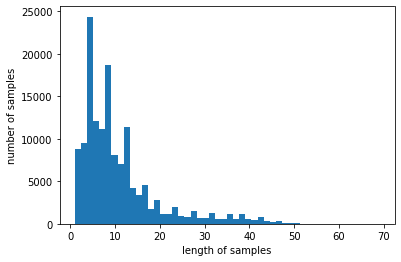

In [ ]:
# 패딩
# 패딩을 위해 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아본다.

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 대부분의 리뷰가 내용이 잘리지 않도록 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만들어 사용한다.

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
# max_len을 30으로 지정하고 그 분포를 확인해보자.
max_len = 30
below_threshold_len(max_len, X_train)
# 전체 훈련 데이터 중 약 94%의 리뷰가 30이하의 길이를 가지는 것을 확인했다.

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### - LSTM으로 네이버 영화 리뷰 감성 분류하기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# 검증 데이터 손실(val_loss)이 증가하면 조기 종료
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 훈련 과정에서 검증 데이터의 정확도가 가장 높은 모델 저장

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)
# 훈련 데이터 중 20%를 검증 데이터로 사용하면서 정확도 확인

Epoch 1/15
1936/1936 [==============================] - 175s 89ms/step - loss: 0.4353 - acc: 0.7938 - val_loss: 0.3518 - val_acc: 0.8434

Epoch 00001: val_acc improved from -inf to 0.84335, saving model to best_model.h5
Epoch 2/15
1936/1936 [==============================] - 171s 89ms/step - loss: 0.3290 - acc: 0.8568 - val_loss: 0.3358 - val_acc: 0.8544

Epoch 00002: val_acc improved from 0.84335 to 0.85441, saving model to best_model.h5
Epoch 3/15
1936/1936 [==============================] - 171s 89ms/step - loss: 0.3021 - acc: 0.8711 - val_loss: 0.3309 - val_acc: 0.8595

Epoch 00003: val_acc improved from 0.85441 to 0.85947, saving model to best_model.h5
Epoch 4/15
1936/1936 [==============================] - 173s 89ms/step - loss: 0.2814 - acc: 0.8819 - val_loss: 0.3340 - val_acc: 0.8579

Epoch 00004: val_acc did not improve from 0.85947
Epoch 5/15
1936/1936 [==============================] - 172s 89ms/step - loss: 0.2654 - acc: 0.8911 - val_loss: 0.3279 - val_acc: 0.8587

Epoch 00

In [ ]:
# 테스트 데이터에 대해서 정확도 측정
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 20s 13ms/step - loss: 0.3376 - acc: 0.8554

 테스트 정확도: 0.8554


### - 리뷰 예측해보기

In [ ]:
# 현재 학습한 model에 새로운 입력에 대해서 예측값을 얻기위해 model.predict()를 사용
# 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력하여 사용

def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('영화의 주제가 뭔지 모르겠음')

54.47% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('기대보다는 스토리가 큰 감흥은 없습니다 연기는 잔잔하게 볼 만 합니다')

54.47% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('어려운 시대를 담담히 풀어나갔거 같습니다.')

54.47% 확률로 부정 리뷰입니다.



### 3) Multi-Kernel 1D CNN으로 네이버 영화 리뷰 분류하기

In [ ]:
# 다수의 커널을 사용할 경우에는 Funtional API를 사용

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
embedding_dim = 128
dropout_prob = (0.5, 0.8) #임베딩 층 이후에는 50% 드롭아웃
num_filters = 128

In [ ]:
model_input = Input(shape = (max_len,)) #max_len = 30
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
# 단어 집합의 크기(vocab_size) : 19416
z = Dropout(dropout_prob[0])(z)

In [ ]:
# 3, 4, 5의 크기를 가지는 커널을 각각 128개 사용

conv_blocks =[]

for sz in [3,4,5]:
    conv = Conv1D(filters = num_filters,
                  kernel_size = sz,
                  padding = 'valid',
                  activation = 'relu',
                  strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv) #maxpooling
    conv = Flatten()(conv)
    conv_blocks.append(conv)

In [ ]:
# 각각 maxpooling한 결과를 연결(concatenate) 한다.
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['acc'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_data = (X_test, y_test), verbose=2, callbacks=[es, mc])

Epoch 1/10
2269/2269 - 151s - loss: 0.4263 - acc: 0.7990 - val_loss: 0.3656 - val_acc: 0.8415

Epoch 00001: val_acc improved from -inf to 0.84152, saving model to CNN_model.h5
Epoch 2/10
2269/2269 - 148s - loss: 0.3433 - acc: 0.8527 - val_loss: 0.3572 - val_acc: 0.8436

Epoch 00002: val_acc improved from 0.84152 to 0.84357, saving model to CNN_model.h5
Epoch 3/10
2269/2269 - 147s - loss: 0.3130 - acc: 0.8682 - val_loss: 0.3553 - val_acc: 0.8457

Epoch 00003: val_acc improved from 0.84357 to 0.84570, saving model to CNN_model.h5
Epoch 4/10
2269/2269 - 148s - loss: 0.2915 - acc: 0.8799 - val_loss: 0.3576 - val_acc: 0.8452

Epoch 00004: val_acc did not improve from 0.84570
Epoch 5/10
2269/2269 - 148s - loss: 0.2735 - acc: 0.8872 - val_loss: 0.3606 - val_acc: 0.8446

Epoch 00005: val_acc did not improve from 0.84570
Epoch 6/10
2269/2269 - 147s - loss: 0.2596 - acc: 0.8941 - val_loss: 0.3689 - val_acc: 0.8437

Epoch 00006: val_acc did not improve from 0.84570
Epoch 7/10
2269/2269 - 149s - l

In [ ]:
#  저장한 모델을 로드하여 테스트 데이터에 대해서 평가한다.
loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 10s 6ms/step - loss: 0.3553 - acc: 0.8457

 테스트 정확도: 0.8457


In [ ]:
# 리뷰 예측해보기
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('영화의 주제가 뭔지 모르겠음')

95.40% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('기대보다는 스토리가 큰 감흥은 없습니다 연기는 잔잔하게 볼 만 합니다')

83.91% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('어려운 시대를 담담히 풀어나갔거 같습니다.')

60.51% 확률로 긍정 리뷰입니다.

